In [354]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
from scipy.fft import fft
import math
import random
from tqdm import tqdm

In [396]:
###...........DFT 0 Method...........###

# Generate s_tone(n)
def generate_s_tone(Fs, f0, phi0, M):
    n = np.arange(M)
    s_tone = np.cos((2 * np.pi * f0 * n )/Fs + phi0)
    return n, s_tone

# Estimate frequency and phase with DFT⁰
def estimate_frequency_and_phase(s_tone, Fs, M, N_DFT, window_type):
    
    window = get_window(window_type, M)
    s_tone = s_tone * window

    # Zero-pad the signal to length N_DFT
    s_tone_padded = np.pad(s_tone, (0, N_DFT - M), 'constant')

    # Compute the DFT
    X = fft(s_tone_padded, N_DFT)

    # Find the peak in the magnitude spectrum
    magnitude_spectrum = np.abs(X) # Magnitude of the DFT (Amplitude)
    k_max = np.argmax(magnitude_spectrum) # Maximum Amplitude
    f0_estimated = k_max*(Fs)/(N_DFT) # estimated frequency of the single tone

    # Estimate the phase
    phi0_estimated = np.angle(X[k_max]) # Argument (angle) of the DFT function

    return f0_estimated, phi0_estimated

###...........DFT 1 Method...........###

def estimate_frequency_and_phase_derivative(s_tone, Fs, M, N_DFT, window_type):

    ###......Estimate the frequency......###
    s_tone_unmodified = s_tone
    # Get the window type
    window = get_window(window_type, M-1)
    
    # Calculate the approx. first derivative of single tone
    s_tone_diff = Fs * np.diff(s_tone)
    s_tone = s_tone[1:]

    # Windowing
    s_tone_windowed = s_tone * window
    s_tone_diff_windowed = s_tone_diff * window

    # Zero-Padding of the signal
    s_tone_padded = np.pad(s_tone_windowed, (0, N_DFT - M), 'constant')
    s_tone_padded_diff = np.pad(s_tone_diff_windowed, (0, N_DFT - M), 'constant')

    # Calculate the DFT
    X = fft(s_tone_padded,n=N_DFT)
    X_diff = fft(s_tone_padded_diff,n=N_DFT)

    # Compute the amplitude spectrum and max. amplitude
    abs_X = np.abs(X)
    k_max = np.argmax(abs_X)
    abs_X_diff = np.abs(X_diff)

    # Estimated frequency of the single tone
    F_kmax = (np.pi * k_max) / (N_DFT * np.sin(np.pi * k_max/ N_DFT))
    f0_estimated = (F_kmax * abs_X_diff[k_max]) / (2 * np.pi * abs_X[k_max])

    # Validate the frequency result
    k_DFT = (N_DFT * f0_estimated) / Fs
    try:
        k_DFT >= (k_max - 0.5) and k_DFT < (k_max + 0.5)
    except ValueError: print("estimated frequency is not valid")

    ###......Estimate the phase......###
    # Calculate phase with DFT⁰ method to compare the values
    _, phi_DFT0 = estimate_frequency_and_phase(s_tone_unmodified, Fs, M, N_DFT, window_type)

    omega_0 = 2*np.pi*f0_estimated/Fs
    k_low = math.floor(k_DFT)
    k_high = math.ceil(k_DFT)

    theta_low = np.angle(X_diff[k_low])
    theta_high = np.angle(X_diff[k_high])
    theta = (k_DFT - k_low) * (theta_high - theta_low) / (k_high - k_low) + theta_low

    numerator = np.tan(theta) * (1 - np.cos(omega_0)) + np.sin(omega_0)
    denominator = 1 - np.cos(omega_0) - np.tan(theta) * np.sin(omega_0)
    phase_estimated = np.arctan(numerator/denominator)
    
    # Calculate both possible values of phi and compare them
    phi_1 = phase_estimated 
    phi_2 = phase_estimated + np.pi if np.arctan(phase_estimated) >= 0 else phase_estimated - np.pi

    if abs(phi_1 - phi_DFT0) < abs(phi_2 - phi_DFT0):  # compare with phi calculated via DFT⁰
        phi = phi_1
    else:
        phi = phi_2

    return f0_estimated, phi

def relative_freq_err(freq, estimate_freq):
    return np.abs(estimate_freq-freq)/freq * 100

def phase_err(phase, estimate_phase):
    return np.degrees(np.abs(phase-estimate_phase))

###...........Generate tone and cut tone...........###
def generate_random_number(min_value, max_value, decimal_places):
    number = random.uniform(min_value, max_value)
    formatted_number = round(number, decimal_places)
    return formatted_number

def create_tones(Fs, M):

    # Generate random sinus waves
    lower_bound_freq = 61.0 # in Hz
    upper_bound_freq = 61.0
    toneSample_num = 100

    frequencies = []
    for i in range(toneSample_num):
        frequencies.append(generate_random_number(lower_bound_freq, upper_bound_freq, 1))
    frequencies = np.array(frequencies)

    phases = []
    for i in range(toneSample_num):
        phases.append(generate_random_number(0, np.pi/2, 1))
    phases = np.array(phases)

    s_tones = []
    for i in range (len(frequencies)):
        n, s_tone = generate_s_tone(Fs, frequencies[i], phases[i], M)
        s_tones.append(s_tone)
    tones = np.array(s_tones)
    
    cut_tones = []
    cut_coords = []
    cut_len = []

    for i in range(len(frequencies)):
        period_length = math.floor(Fs/frequencies[i])
        start_num = int(generate_random_number(100, M-period_length-100, 0)) # Random number between 0 and N - (period length)
        end_num = generate_random_number(0, (period_length-1) , 0) # Random number between 1 and period_length-1)
        end_num = int(start_num + end_num)
        cut_coords.append(start_num)
        cut_tones.append(np.concatenate((tones[i][:start_num], tones[i][end_num:])))
        cut_len.append(np.degrees(2*np.pi*(end_num-start_num)/period_length))
        
    return frequencies, phases, tones, cut_tones, cut_coords, cut_len

def feature_F(phases):
    m_phi = np.sum(phases[1:])/len(phases[1:])
    sum = 0
    N_cycle = len(phases)
    for i in range(1, N_cycle):
        sum+=((phases[i]-phases[i-1])-m_phi)**2
    F = 100* math.log10(1/(N_cycle-1) * sum)
    return F

def feature_phase_extraction(s_tone, frequencies, cut_coords):
    Fs = 1200
    DFT1_F = []
    DFT0_F = []

    for u in tqdm(range(len(s_tone))):

        ### DFT1
        DFT1_cycles = []
        DFT1_phases = []
        period_length = int(Fs/frequencies[u])
        DFT1_cyc = 0

        for i in range(len(s_tone[u])):
            cycle = s_tone[u][i*period_length : i*period_length + 10*period_length]
            if i*period_length <= cut_coords[u] <= i*period_length + 10*period_length: DFT1_cyc = i
            DFT1_cycles.append(cycle)
            if len(cycle) == 10*period_length: continue
            else: break

        N_DFT = 20000
        window_type = 'hann'

        for i in range(len(DFT1_cycles)):
            M = len(DFT1_cycles[i])
            _,phase = estimate_frequency_and_phase_derivative(DFT1_cycles[i], Fs, M, N_DFT, window_type)
            DFT1_phases.append(phase)

        ### DFT0
        DFT0_cycles = []
        DFT0_phases = []
        DFT0_cyc = 0

        for i in range(len(s_tone[u])):
            cycle = s_tone[u][i*period_length : i*period_length + 10*period_length]
            if i*period_length <= cut_coords[u] <= i*period_length + 10*period_length: DFT0_cyc = i
            DFT0_cycles.append(cycle)
            if len(cycle) == 10*period_length: continue
            else: break

        Fs = 1200
        N_DFT = 20000
        window_type = 'hann'

        for i in range(len(DFT0_cycles)):
            M = len(DFT0_cycles[i])
            _,phase = estimate_frequency_and_phase(DFT0_cycles[i], Fs, M, N_DFT, window_type)
            DFT0_phases.append(phase)
        
        DFT0_phases = np.unwrap(DFT0_phases)
        DFT1_phases = DFT1_phases

        DFT0_F.append(feature_F(DFT0_phases))
        DFT1_F.append(feature_F(DFT1_phases))

    return DFT0_F, DFT1_F, DFT0_phases, DFT1_phases, DFT0_cyc, DFT1_cyc

def find_optimal_lambda(uncut, cut):

    combined = np.concatenate((uncut, cut))
    combined.sort()
    
    # Initialize variables to track the best lambda and minimum error
    best_lambda = None
    min_error = float('inf')
    
    # Try every possible threshold
    for i in tqdm(range(1, len(combined))):
        lambda_candidate = (combined[i-1] + combined[i]) / 2
        
        # Classify based on current lambda
        error_uncut = np.sum(uncut < lambda_candidate)  # Errors in uncut
        error_cut = np.sum(cut >= lambda_candidate)  # Errors in cut
        
        # Total classification error
        total_error = error_uncut + error_cut
        
        # Update the best lambda if the current total error is lower
        if total_error < min_error:
            min_error = total_error
            best_lambda = lambda_candidate
    
    return best_lambda, min_error

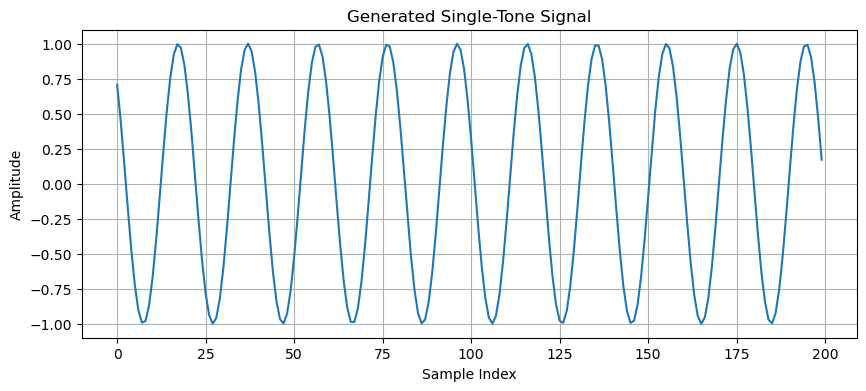

Estimated frequency: 60.888 Hz
Estimated phase: 0.7864636008592417 radians


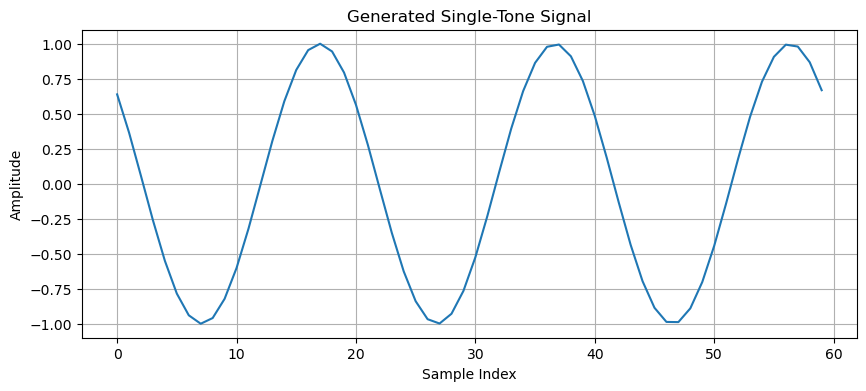

In [356]:
# Example usage
Fs = 1200 # Sampling frequency (Hz)
f0 = 60.89  # Frequency of the tone (Hz)
phi0 = np.pi/4  # Phase of the tone (radians)
M = 200 # Number of samples
N_DFT = 200000
window_type = 'hann'  # Optional window type (e.g., 'hann', 'hamming', etc.)

# Generate the signal
n, s_tone = generate_s_tone(Fs, f0, phi0, M)

#Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(n, s_tone)
plt.title('Generated Single-Tone Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Estimate frequency and phase
f0_estimated, phi0_estimated = estimate_frequency_and_phase(s_tone, Fs, M, N_DFT, window_type)
print(f"Estimated frequency: {f0_estimated} Hz")
print(f"Estimated phase: {phi0_estimated} radians")

period_length = int(np.round(Fs/f0))
cycle = s_tone[period_length : period_length + 3*period_length]
n_cycle = np.arange(len(cycle))

#Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(n_cycle, cycle)
plt.title('Generated Single-Tone Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [357]:
# Example usage
Fs = 1200 # Sampling frequency (Hz)
f0 = 60.98 # Frequency of the tone (Hz)
phi0 = np.pi/4 # Phase of the tone (radians)
M =  200 # Number of samples
N_DFT = 20000
window_type = 'hann'  # Optional window type (e.g., 'hann', 'hamming', etc.)

# Generate the signal
n, s_tone = generate_s_tone(Fs, f0, phi0, M)

frequency_estimated, phase_estimated = estimate_frequency_and_phase_derivative(s_tone, Fs, M, N_DFT, window_type)
print(f"Estimated frequency: {frequency_estimated:.6f} Hz")
print(f"Estimated phase: {phase_estimated:.6f} radians")

Estimated frequency: 60.977069 Hz
Estimated phase: 0.786920 radians


In [366]:
# Paper Errors Comparision
Fs = 1200
f0 = 60.98
phi0 = np.pi/4 # Phase of the tone (radians)
M = [60,100,200]
N_DFT = [200,2000,20000]
window_type = 'hann'

for i in range(len(M)):
    for j in range(len(N_DFT)):
        n, s_tone = generate_s_tone(Fs, f0, phi0, M[i])
        DFT1_freq, DFT1_phi = estimate_frequency_and_phase_derivative(s_tone, Fs, M[i], N_DFT[j], window_type)
        DFT0_freq, DFT0_phi = estimate_frequency_and_phase(s_tone, Fs, M[i], N_DFT[j], window_type)

        DFT1_freq_err = relative_freq_err(f0, DFT1_freq)
        DFT0_freq_err = relative_freq_err(f0, DFT0_freq)

        DFT1_phi_err = phase_err(phi0, DFT1_phi)
        DFT0_phi_err = phase_err(phi0, DFT0_phi)

        print(f'For DFT1 with M={M[i]} and N_DFT={N_DFT[j]}: Freq. err. = {DFT1_freq_err} and phase err. = {DFT1_phi_err}')
        print(f'For DFT0 with M={M[i]} and N_DFT={N_DFT[j]}: Freq. err. = {DFT0_freq_err} and phase err. = {DFT0_phi_err}\n')

For DFT1 with M=60 and N_DFT=200: Freq. err. = 0.008902786099184273 and phase err. = 0.04599930516804205
For DFT0 with M=60 and N_DFT=200: Freq. err. = 1.60708428993112 and phase err. = 8.832388508644463

For DFT1 with M=60 and N_DFT=2000: Freq. err. = 4.506302123770409e-05 and phase err. = 0.000723723462405115
For DFT0 with M=60 and N_DFT=2000: Freq. err. = 0.36077402427026234 and phase err. = 1.9537177501947254

For DFT1 with M=60 and N_DFT=20000: Freq. err. = 0.001264775901895866 and phase err. = 0.006005215171786357
For DFT0 with M=60 and N_DFT=20000: Freq. err. = 0.06559527714005617 and phase err. = 0.33570484755893354

For DFT1 with M=100 and N_DFT=200: Freq. err. = 0.011164420153575508 and phase err. = 0.1004159073607637
For DFT0 with M=100 and N_DFT=200: Freq. err. = 1.60708428993112 and phase err. = 14.703988117789383

For DFT1 with M=100 and N_DFT=2000: Freq. err. = 0.006506709527009116 and phase err. = 0.05651525588963874
For DFT0 with M=100 and N_DFT=2000: Freq. err. = 0.36

In [367]:
Fs = 1200
M = 200 # Sample number 
N_DFT = 20000
window_type = 'hann'
DFT1_phi_err = []
DFT1_freq_err = []
DFT0_phi_err = []
DFT0_freq_err = []

frequencies,phases,tones_array,cut_tones_array,cut_coords, cut_len = create_tones(Fs,M)

# DFT1
for i in range(len(frequencies)):
    est_freq, est_phase = estimate_frequency_and_phase_derivative(tones_array[i], Fs, M, N_DFT, window_type)
    #print(f'{phases[i]} and {est_phase}')
    DFT1_phi_err.append(phase_err(phases[i], est_phase))
    DFT1_freq_err.append(relative_freq_err(frequencies[i], est_freq))

# DFT0
for i in range(len(frequencies)):
    est_freq, est_phase = estimate_frequency_and_phase(tones_array[i], Fs, M, N_DFT, window_type)
    DFT0_phi_err.append(phase_err(phases[i], est_phase))
    DFT0_freq_err.append(relative_freq_err(frequencies[i], est_freq ))

print(f'DFT0 average freq. and phi error: {np.sum(DFT0_freq_err)/len(DFT0_freq_err)} and {np.sum(DFT0_phi_err)/len(DFT0_phi_err)}\n')
print(f'DFT1 average freq. and phi error: {np.sum(DFT1_freq_err)/len(DFT1_freq_err)} and {np.sum(DFT1_phi_err)/len(DFT1_phi_err)}')

DFT0 average freq. and phi error: 0.020984965302581936 and 0.3781215135997302

DFT1 average freq. and phi error: 0.002616727158401479 and 1.4601230852475293


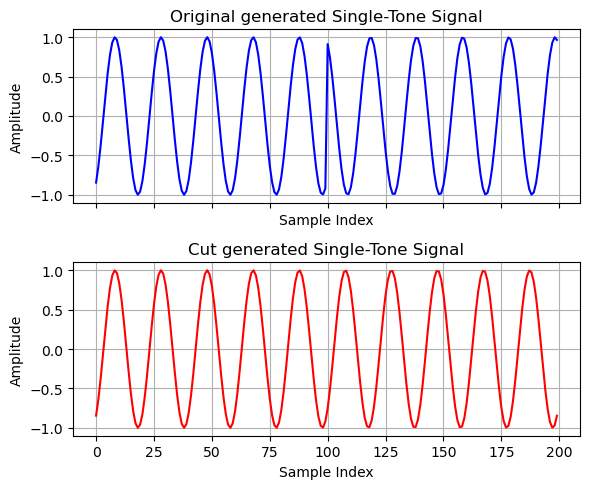

In [360]:
# Create cut tones array
Fs = 1200
M = 2400
frequencies,_,tones_array,cut_tones_array,cut_coords,_ = create_tones(Fs, M)

# Plot an example uncut and cut tone window
specific_cut_tones = cut_tones_array[0][cut_coords[0]-100:cut_coords[0]+100]
specific_tones = tones_array[0][cut_coords[0]-100:cut_coords[0]+100]
n = np.arange(200)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

# Plot für specific_cut_tones
ax1.plot(n, specific_cut_tones, color='b')
ax1.set_title('Original generated Single-Tone Signal')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Amplitude')
ax1.grid()

# Plot für specific_tones
ax2.plot(n, specific_tones, color='r')
ax2.set_title('Cut generated Single-Tone Signal')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Amplitude')
ax2.grid()

# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()

100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Feature for DFT0 uncut and cut: [221.50876682435313] and [210.00401761924272]
Feature for DFT1 uncut and cut: [-20.03928289043646] and [-10.533838574206964]


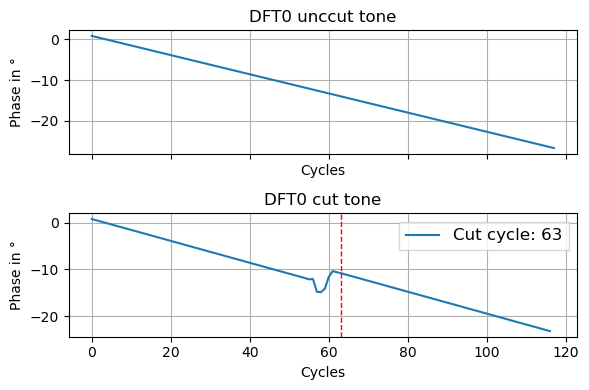

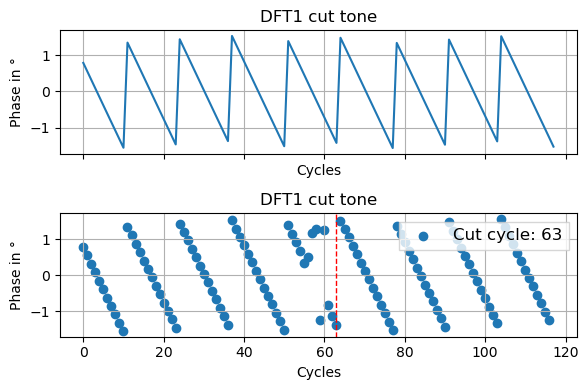

In [397]:
### Example cut and uncut tone
Fs = 1200 # Sampling frequency (Hz)
f0 = 60.8 # Frequency of the tone (Hz)
phi0 = np.pi/4 # Phase of the tone (radians)
window_type = 'hann'  # Optional window type (e.g., 'hann', 'hamming', etc.)
Ds = 2 # 10s Audiodatei
M = Fs * Ds # Sample number
N_DFT = 20000 


# Generate the signal
n, s_tone = generate_s_tone(Fs, f0, phi0, M)
period_len= int(np.round(Fs/f0))
cut_tone = np.concatenate((s_tone[:1200], s_tone[int(1200+0.5*period_len):]))

DFT0_F_uncut, DFT1_F_uncut, uncut_DFT0_phases, uncut_DFT1_phases, _, _= feature_phase_extraction([s_tone], [f0], [1200])
DFT0_F_cut, DFT1_F_cut, cut_DFT0_phases, cut_DFT1_phases, DFT0_cyc, DFT1_cyc = feature_phase_extraction([cut_tone], [f0], [1200])

n_cut_DFT0 = np.arange(len(cut_DFT0_phases))
n_cut_DFT1 = np.arange(len(cut_DFT1_phases))
n_uncut_DFT0 = np.arange(len(uncut_DFT0_phases))
n_uncut_DFT1 = np.arange(len(uncut_DFT1_phases))

print(f'Feature for DFT0 uncut and cut: {DFT0_F_uncut} and {DFT0_F_cut}')
print(f'Feature for DFT1 uncut and cut: {DFT1_F_uncut} and {DFT1_F_cut}')

### DFT0 Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.plot(n_uncut_DFT0, uncut_DFT0_phases)
ax1.set_title('DFT0 unccut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.plot(n_cut_DFT0, cut_DFT0_phases, label = f'Cut cycle: {DFT0_cyc}')
ax2.set_title('DFT0 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
ax2.legend(fancybox=False, loc="best", fontsize=12)
ax2.axvline(x=DFT0_cyc, color='red', linestyle='--', linewidth = 1)
plt.tight_layout()
plt.show()


### Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.plot(n_uncut_DFT1, uncut_DFT1_phases)
ax1.set_title('DFT1 cut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.scatter(n_cut_DFT1, cut_DFT1_phases, label = f'Cut cycle: {DFT0_cyc}')
ax2.set_title('DFT1 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
ax2.legend(fancybox=False, loc="best", fontsize=12)
ax2.axvline(x=DFT0_cyc, color='red', linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

Frequenciec = 61.0Hz and phase = 11.459155902616466°
Cut Length 189.47368421052633°


100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


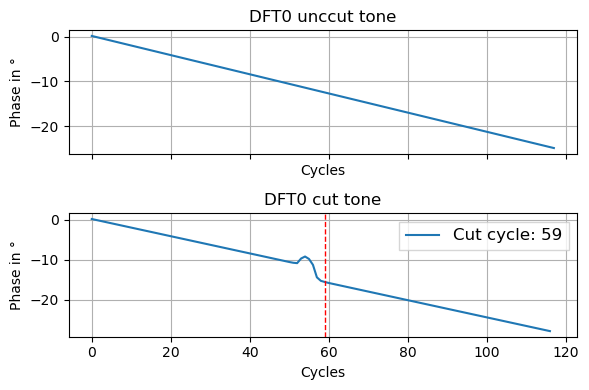

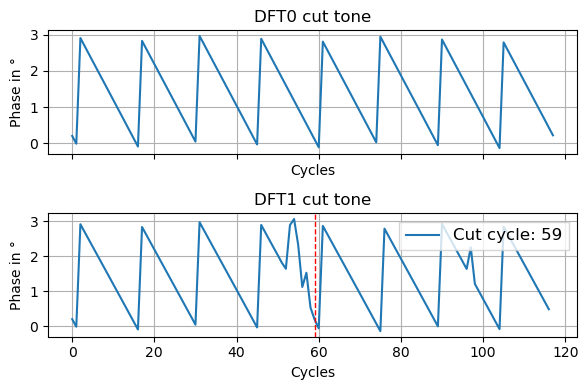

In [382]:
###............................Random generated cut............................###

### Create cut tones array
Fs = 1200
M = 2* Fs
frequencies,phi0,tones_array,cut_tones_array,cut_coords, cut_len = create_tones(Fs,M)

print(f'Frequenciec = {frequencies[0]}Hz and phase = {np.degrees(phi0[0])}°')
print(f'Cut Length {cut_len[0]}°')

_,_, uncut_DFT0_phases, uncut_DFT1_phases, _, _ = feature_phase_extraction([tones_array[0]], [frequencies[0]], [cut_coords[0]])
_,_, cut_DFT0_phases, cut_DFT1_phases, DFT0_cyc, DFT1_cyc = feature_phase_extraction([cut_tones_array[0]], [frequencies[0]], [cut_coords[0]])

n_cut_DFT0 = np.arange(len(cut_DFT0_phases))
n_cut_DFT1 = np.arange(len(cut_DFT1_phases))
n_uncut_DFT0 = np.arange(len(uncut_DFT0_phases))
n_uncut_DFT1 = np.arange(len(uncut_DFT1_phases))

### DFT0 Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.plot(n_uncut_DFT0, uncut_DFT0_phases)
ax1.set_title('DFT0 unccut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.plot(n_cut_DFT0, cut_DFT0_phases, label = f'Cut cycle: {DFT0_cyc}')
ax2.set_title('DFT0 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
ax2.legend(fancybox=False, loc="best", fontsize=12)
ax2.axvline(x=DFT0_cyc, color='red', linestyle='--', linewidth = 1)
plt.tight_layout()
plt.show()


### Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.plot(n_uncut_DFT1, uncut_DFT1_phases)
ax1.set_title('DFT0 cut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.plot(n_cut_DFT1, cut_DFT1_phases, label = f'Cut cycle: {DFT0_cyc}')
ax2.set_title('DFT1 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
ax2.legend(fancybox=False, loc="best", fontsize=12)
ax2.axvline(x=DFT0_cyc, color='red', linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

In [ ]:
# Feature extraction for 1000 different cuts 
print(f'Cut feature for DFT0 for 1 measurement {feature_F(len(n_DFT0), DFT0_phases)}')
print(f'Cut feature for DFT1 for 1 measurement {feature_F(len(n_DFT1), DFT1_phases)}')
print(f'\nCut feature for DFT0 for 1000 measurement {308.6215071069567}')
print(f'Uncut feature for DFT0 for 1000 measurement {303.2633346648716}')
print(f'\nCut feature for DFT1 for 1000 measurement {276.04565806410335}')
print(f'Uncut feature for DFT1 for 1000 measurement {271.839816549829}')

In [383]:
### Create cut tones array
Fs = 1200
M = 10* Fs
frequencies,phi0,tones_array,cut_tones_array,cut_coords, cut_len = create_tones(Fs, M)
F_uncutDFT0, F_uncutDFT1,_,_,_,_= feature_phase_extraction(tones_array, frequencies, cut_coords)  
F_cutDFT0, F_cutDFT1,_,_,_,_ = feature_phase_extraction(cut_tones_array, frequencies, cut_coords)

100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


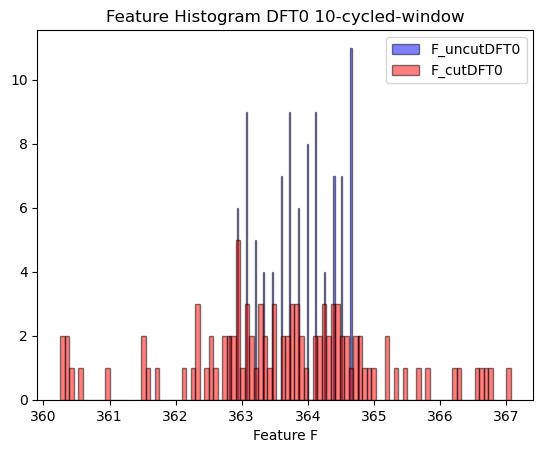

In [392]:
# Create histograms
plt.hist(F_uncutDFT0, bins = 100, color='blue', alpha=0.5, edgecolor='black', label='F_uncutDFT0')
plt.hist(F_cutDFT0, bins = 100, color='red', alpha=0.5, edgecolor='black', label='F_cutDFT0')

# Add titles and labels
plt.title('Feature Histogram DFT0 10-cycled-window')
plt.xlabel('Feature F')
plt.legend()
#plt.savefig("Feature Histogram DFT0 10-cycled-window.pdf")
plt.show()
#print(len(F_uncutDFT0))
#print(len(F_cutDFT0))
#print(F_uncutDFT0)

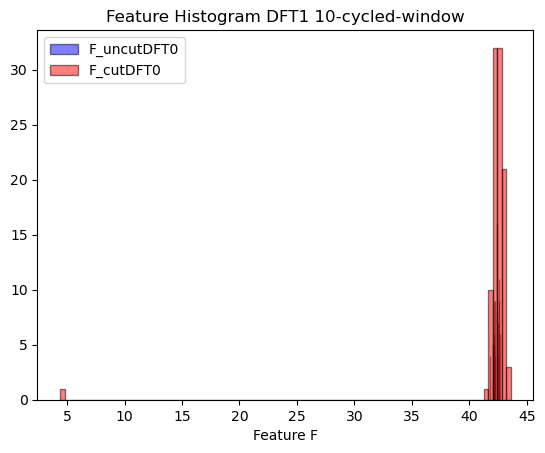

In [390]:
# Create histograms
plt.hist(F_uncutDFT1, bins=100, color='blue', alpha=0.5, edgecolor='black', label='F_uncutDFT0')
plt.hist(F_cutDFT1, bins=100, color='red', alpha=0.5, edgecolor='black', label='F_cutDFT0')

# Add titles and labels
plt.title('Feature Histogram DFT1 10-cycled-window')
plt.xlabel('Feature F')
plt.legend()
#plt.savefig("Feature Histogram DFT1 10-cycled-window.pdf")
plt.show()

In [391]:
# Choose a lambda to minimise the error
optimal_lambda_DFT0, error_DFT0 = find_optimal_lambda(F_uncutDFT0, F_cutDFT0)
optimal_lambda_DFT1, error_DFT1 = find_optimal_lambda(F_uncutDFT1, F_cutDFT1)
print(f'Lambda and error for DFT0 phase estimation: {optimal_lambda_DFT0} and {error_DFT0}')
print(f'\nLambda and error for DFT1 phase estimation: {optimal_lambda_DFT1} and {error_DFT1}')

100%|██████████| 199/199 [00:00<00:00, 67661.03it/s]

Lambda and error for DFT0 phase estimation: 362.9352898469665 and 74

Lambda and error for DFT1 phase estimation: 42.06791620694841 and 91
